In [47]:
import numpy as np
import matplotlib.pyplot as plt

from fastprogress import progress_bar
import math

import jlinops
import sampi

In [2]:
class ObjectiveTerm:
    """Represents a term in an objective function.
    n: length of expected input vector.
    """
    def __init__(self, n, device="cpu"):
        
        self.device = device
        self.n = n
        
    def evaluate(self, x):
        raise NotImplementedError

In [208]:
class SmoothObjectiveTerm(ObjectiveTerm):
    """Represents a smooth term in an objective function.
    """
    def __init__(self, n, device="cpu"):
            
        super().__init__(n, device)
                 
                 
class GaussianDataLikelihood(SmoothObjectiveTerm):
    """Represents a Gaussian data fidelity term in an objective function. 
    Looks like: 
    
    E(x) = (1/(2*v))*|| A x - b ||_2^2
    
    A: a LinearOperator.
    b: a shift vector.
    
    """
    
    def __init__(self, A, b, v=1.0, est_smoothness=True):
        
        n = A.shape[1]
        device = A.device
        super().__init__(n, device)
        
        self.A = A
        self.b = b
        self.v = 1.0
        
        # Estimate L s.t. this factor is L-smooth.
        if est_smoothness:
            # L = 2-norm of the matrix (1/v)*self.A.T @ self.A
            eigvals, _ = jlinops.eigsh( (1.0/v)*(self.A.T @ self.A), k=1, which="LM")
            max_eigval = eigvals[0]
            self.L = 1.05*max_eigval # increase by small safe-guard factor
        else:
            self.L = None
        
    def evaluate(self, x):
        xp = jlinops.get_module(x)
        fac = (1.0/(2*self.v))
        result = fac*xp.linalg.norm(self.A.matvec(x) - self.b)**2
        return result
        
    def evaluate_grad(self, x):
        return (1/self.v)*self.A.rmatvec(self.A.matvec(x) - self.b)

In [209]:
class ConvexNonsmoothObjectiveTerm(ObjectiveTerm):
    """Represents a convex, nonsmooth term in an objective function.
    """
    
    def __init__(self, n, device="cpu"):
            
        super().__init__(n, device)
    
    def evaluate_prox(self, x, lam=None, rho=None):
        raise NotImplementedError
    

In [210]:
class TVNeumann2DPenalty(ConvexNonsmoothObjectiveTerm):
    """Represents a 1-norm 2D-TV penalty where the TV operator is a 2D
    discrete gradient operator with Neumann boundary conditions. Looks like
    E(x) = reg_lam*|| R x ||_1
    """
    def __init__(self, grid_shape, reg_lam=1.0, device="cpu"):
        
        self.grid_shape = grid_shape
        self.reg_lam = reg_lam
        
        # Build the proximal operator object
        self._prox_solver = jlinops.ProxTVNeumann2DNormOperator( grid_shape )
        n = self._prox_solver.D.shape[1]
        self.D = self._prox_solver.D
        
        super().__init__(n, device)
        
    def evaluate(self, x):
        xp = jlinops.get_module(x)
        return self.reg_lam*xp.abs( self.D.matvec(x) ).sum()
        
    def evaluate_prox(self, x, lam=None, rho=None, *args, **kwargs):
        
        return self._prox_solver.apply(x, lam=self.reg_lam*lam, rho=rho, *args, **kwargs)
        

In [211]:
class ObjectiveFunction:
    """Base class for representing an objective function.
    
    terms: a list of 
    """
    
    def __init__(self, terms):
        
        self.terms = terms
        device = self.terms[0].device
        n = self.terms[0].n
        for term in self.terms[1:]:
            assert term.device == device, "devices not compatible."
            assert term.n == n, "expected inputs not compatible."
            
        self.device = device
        self.n = n
            
    def evaluate(self, x):
        result = 0.0
        for term in self.terms:
            result += term.evaluate(x)
        return result

In [212]:
class CompositeModelObjectiveFunction(ObjectiveFunction):
    """Represents an objective function conforming to the composite model, i.e.,
    F(x) = f(x) + g(x) where
    f(x) is proper, closed, dom(f) is convex, dom(g) \subseteq int(dom(f)), and L_f smooth, and
    g(x) is proper closed and convex.
    
    The gradient of f must be defined.
    The proximal operator of g must be defined.
    """
    def __init__(self, f, g):
        
        terms = [f, g]
        super().__init__(terms)
        
        # Check valid
        assert isinstance(f, SmoothObjectiveTerm), "f must be a SmoothObjectiveTerm."
        assert isinstance(g, ConvexNonsmoothObjectiveTerm), "g must be a ConvexNonsmoothObjectiveTerm."
        
        
    

In [229]:
class ProximalGradientSolver:
    """Represents a proximal gradient solver.
    
    objective: must be a CompositeModelObjectiveFunction
    """
    
    def __init__(self, objective):
        
        # Check
        assert isinstance(objective, CompositeModelObjectiveFunction)
        self.objective = objective
        self.f, self.g = self.objective.terms   
        
        
    def solve(self, iterations=20, L=None, initialization=None):
        
        if initialization is None:
            x = np.zeros(self.objective.n)
        else:
            x = initialization
            
        if L is None:
            assert self.f.L is not None, "must provide stepsize, can't pick default."
            L = self.f.L
        
        obj_vals = []
        for i in progress_bar(range(iterations)):
            
            grad_step = x - (1.0/L)*self.f.evaluate_grad(x)
            x = self.g.evaluate_prox(grad_step, lam=1.0/L)
            
            # Track value
            obj_vals.append(self.objective.evaluate(x))
            
        data = {
            "result": x,
            "obj_vals": np.asarray(obj_vals),
        }
              
        return data
        
    
    def line_search(self):
        """Line search method.
        """
        pass
        
    

In [230]:
class FISTASolver:
    """Represents a FISTA solver.
    
    objective: must be a CompositeModelObjectiveFunction
    """
    
    def __init__(self, objective):
        
        # Check
        assert isinstance(objective, CompositeModelObjectiveFunction)
        self.objective = objective
        self.f, self.g = self.objective.terms   
        
        
    def solve(self, iterations=20, L=None, initialization=None):
        
        if initialization is None:
            x_prev = np.zeros(self.objective.n)
        else:
            x_prev = initialization
            
        if L is None:
            assert self.f.L is not None, "must provide stepsize, can't pick default."
            L = self.f.L
            
        y = x_prev.copy()
        t_prev = 1.0
        
        obj_vals = []
        for i in progress_bar(range(iterations)):
            
            grad_step = y - (1.0/L)*self.f.evaluate_grad(y)
            x_curr = self.g.evaluate_prox(grad_step, lam=1.0/L)
            t_curr = 0.5*(1 + np.sqrt(1 + 4*(t_prev**2)))
            y = x_curr + ((t_prev - 1.0)/t_curr)*( x_curr - x_prev )
            
            # Advance
            t_prev = t_curr
            x_prev = x_curr
            
            # Track value
            obj_vals.append(self.objective.evaluate(x_curr))
            
        data = {
            "result": x_curr,
            "obj_vals": np.asarray(obj_vals),
        }
              
        return data
        
    
    def line_search(self):
        """Line search method.
        """
        pass
        
    

In [264]:
class MFISTASolver:
    """Represents a MFISTA solver.
    
    objective: must be a CompositeModelObjectiveFunction
    """
    
    def __init__(self, objective):
        
        # Check
        assert isinstance(objective, CompositeModelObjectiveFunction)
        self.objective = objective
        self.f, self.g = self.objective.terms   
        
        
    def solve(self, iterations=20, L=None, initialization=None):
        
        if initialization is None:
            x_prev = np.zeros(self.objective.n)
        else:
            x_prev = initialization
            
        if L is None:
            assert self.f.L is not None, "must provide stepsize, can't pick default."
            L = self.f.L
            
        y = x_prev.copy()
        t_prev = 1.0
        
        obj_vals = []
        for i in progress_bar(range(iterations)):
            
            grad_step = y - (1.0/L)*self.f.evaluate_grad(y)
            z = self.g.evaluate_prox(grad_step, lam=1.0/L)
            
            F_z = self.objective.evaluate(z)
            F_x = self.objective.evaluate(x_prev)
            if F_z < F_x:
                x_curr = z
            else:
                x_curr = x_prev
       
            t_curr = 0.5*(1 + np.sqrt(1 + 4*(t_prev**2)))
            y = x_curr + (t_prev/t_curr)*(z - x_curr) + ((t_prev - 1.0)/t_curr)*( x_curr - x_prev )
            
            # Advance
            t_prev = t_curr
            x_prev = x_curr
            
            # Track value
            obj_vals.append(self.objective.evaluate(x_curr))
            
        data = {
            "result": x_curr,
            "obj_vals": np.asarray(obj_vals),
        }
              
        return data
        
    
    def line_search(self):
        """Line search method.
        """
        pass
        
    

# Set up a toy problem

In [265]:
ground_truth = jlinops.cameraman()
noise_sigma = 0.05
blur_sigma = 1.0
noise_var = noise_sigma**2
np.random.seed(0)
F = jlinops.Gaussian2DBlurOperator(ground_truth.shape, blur_sigma=blur_sigma)
noisy_signal = F.matvec_shaped(ground_truth) + noise_sigma*np.random.normal(size=ground_truth.shape)

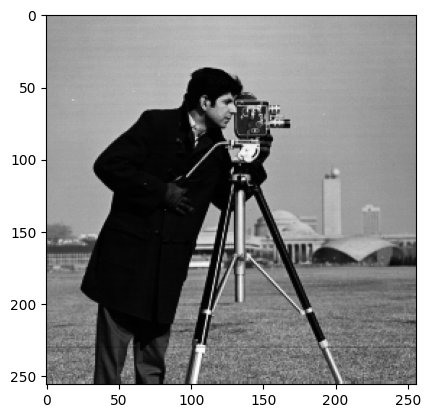

In [266]:
plt.imshow(ground_truth, cmap="gray")
plt.show()

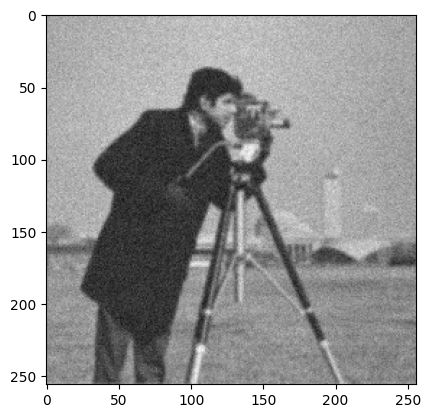

In [267]:
plt.imshow(noisy_signal, cmap="gray")
plt.show()

# Build objective function

In [268]:
# Data likelihood term
f = GaussianDataLikelihood(F, noisy_signal.flatten(), v=noise_var)

In [269]:
# Regularization term
g = TVNeumann2DPenalty(noisy_signal.shape, reg_lam=1e-2)

In [270]:
obj = CompositeModelObjectiveFunction(f, g)

In [271]:
print(f"L = {f.L}")

L = 419.9999999999994


# Instantiate solver

In [272]:
solver = ProximalGradientSolver(obj)

In [273]:
solver_data = solver.solve(iterations=1000, L=None)

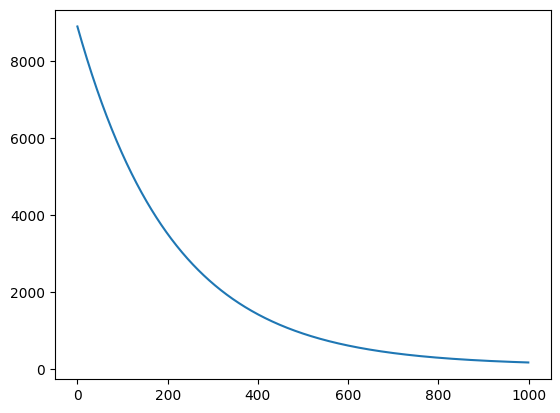

In [274]:
plt.plot(solver_data["obj_vals"])
plt.show()

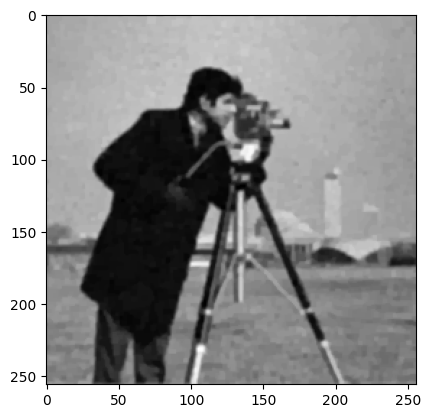

In [275]:
plt.imshow(solver_data["result"].reshape(ground_truth.shape), cmap="gray")
plt.show()

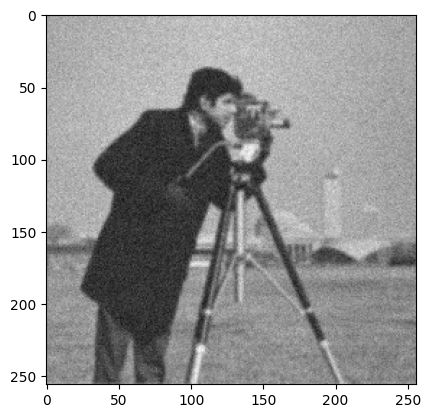

In [276]:
plt.imshow(noisy_signal, cmap="gray")
plt.show()

In [277]:
fista_solver = FISTASolver(obj)

In [278]:
fista_solver_data = fista_solver.solve(iterations=1000, L=None)

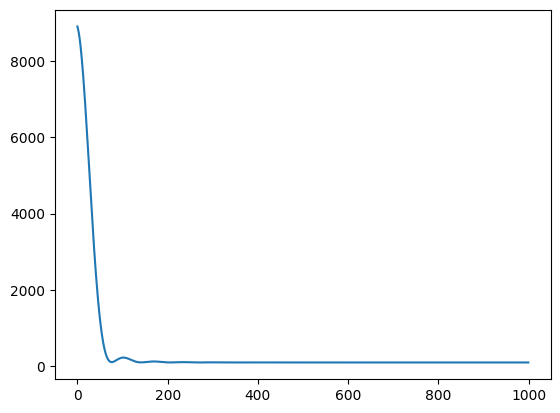

In [279]:
plt.plot(fista_solver_data["obj_vals"])
plt.show()

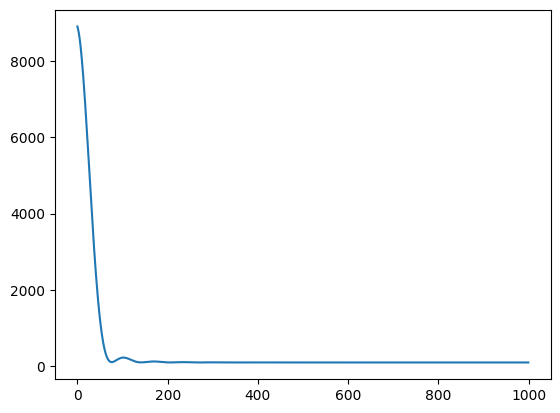

In [280]:
plt.plot(fista_solver_data["obj_vals"])
plt.show()

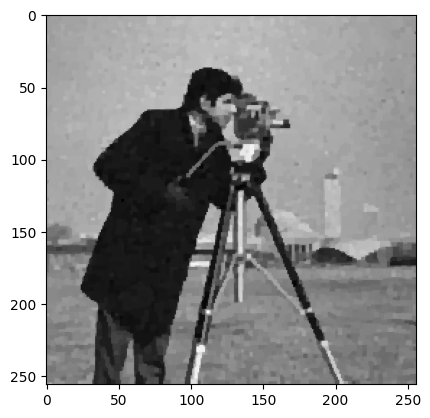

In [281]:
plt.imshow(fista_solver_data["result"].reshape(ground_truth.shape), cmap="gray")
plt.show()

In [282]:
mfista_solver = MFISTASolver(obj)

In [283]:
mfista_solver_data = mfista_solver.solve(iterations=1000, L=None)

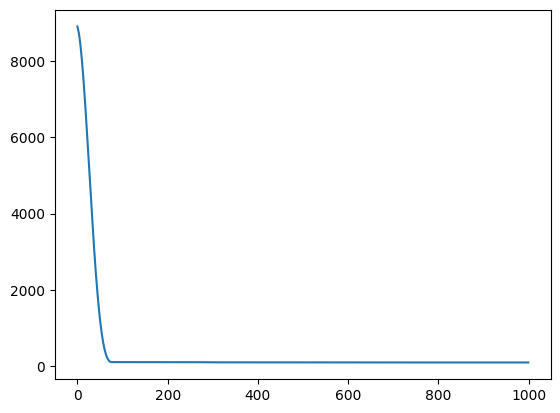

In [284]:
plt.plot(mfista_solver_data["obj_vals"])
plt.show()

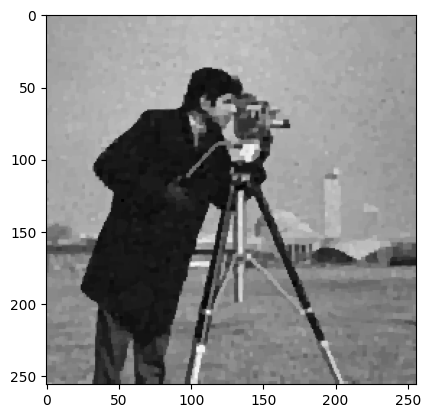

In [286]:
plt.imshow(mfista_solver_data["result"].reshape(ground_truth.shape), cmap="gray")
plt.show()

# Compare

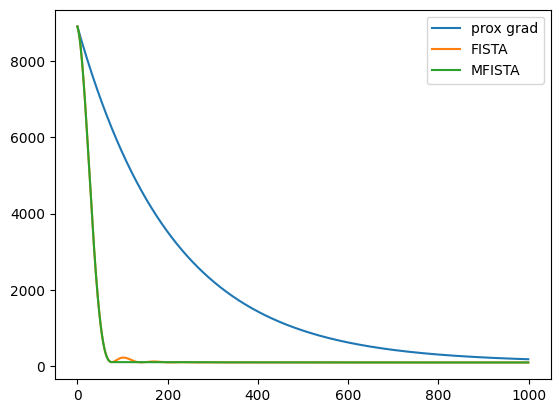

In [288]:
plt.plot(solver_data["obj_vals"], label="prox grad")
plt.plot(fista_solver_data["obj_vals"], label="FISTA")
plt.plot(mfista_solver_data["obj_vals"], label="MFISTA")
plt.legend()
plt.show()